# Clustering climat

In [ ]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(maps)
library(ggrepel)
library(dendextend)

library(ggplot2)
library(maps)
library(FNN)
library(sp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



---------------------
Welcome to dendextend version 1.19.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:


L'objectif de cette section est d'essayer de retrouver les différents types de climats en France métropolitaine, à partir de notre jeu de données. Pour cela, nous effectuons un clustering sur les différentes stations, en des moyennes et écarts-types de différentes grandeurs (température, humidité, vent, précipitations, nébulosité).

Dans un premier temps, nous sélectionnons tout ça et mettons tout dans 'stations_france'.

In [13]:
stations_climat <- observations %>%
  group_by(ID.OMM.station, Latitude, Longitude, Altitude) %>%
  summarise(temp_moy = mean(Température, na.rm=TRUE),
            temp_sd = sd(Température, na.rm=TRUE),
            temp_ete = mean(Température[month(Date) %in% c(6,7,8)], na.rm=TRUE),
            temp_hiver = mean(Température[month(Date) %in% c(12,1,2)], na.rm=TRUE),
            hum_moy = mean(Humidité, na.rm=TRUE),
            hum_sd = sd(Humidité, na.rm=TRUE),
            vent_moy = mean(Vitesse.du.vent.moyen.10.mn, na.rm=TRUE),
            vent_sd = sd(Vitesse.du.vent.moyen.10.mn, na.rm=TRUE),
            precip_moy = mean(Précipitations.dans.les.24.dernières.heures, na.rm=TRUE),
            precip_sd = sd(Précipitations.dans.les.24.dernières.heures, na.rm=TRUE),
            nebul_moy = mean(Nebulosité.totale, na.rm=TRUE),
            .groups = "drop")

stations_climat <- stations_climat %>%
  left_join(stations %>% 
              select(ID.OMM.station, communes..name., department..name., region..name.),
            by = "ID.OMM.station")

stations_france <- stations_climat %>%
  filter(Latitude >= 42, Latitude <= 51,
         Longitude >= -5, Longitude <= 10)

head(stations_france)

ID.OMM.station,Latitude,Longitude,Altitude,temp_moy,temp_sd,temp_ete,temp_hiver,hum_moy,hum_sd,vent_moy,vent_sd,precip_moy,precip_sd,nebul_moy,communes..name.,department..name.,region..name.
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
7005,50.13600,1.834000,69,284.7995,6.329857,291.1003,278.8929,80.33446,15.00129,3.600912,2.252659,2.194954,4.575288,72.55759,Abbeville,Somme,Hauts-de-France
7015,50.57000,3.097500,47,285.1373,6.913029,292.2792,278.5218,77.25565,17.06096,4.178517,2.452241,1.924008,4.172185,96.49914,Fretin,Nord,Hauts-de-France
7020,49.72517,-1.939833,6,285.9265,4.035360,289.8773,282.0276,81.67951,10.40275,6.758472,3.573506,2.088533,4.540331,69.14118,La Hague,Manche,Normandie
7027,49.18000,-0.456167,67,285.0625,6.023839,290.9454,279.6901,81.25286,13.97170,4.246815,2.474953,1.898839,4.056612,94.13673,Carpiquet,Calvados,Normandie
7037,49.38300,1.181667,151,284.6429,6.682290,291.3540,278.4196,79.98217,16.44134,4.039976,2.133913,2.130887,4.228155,94.67241,Boos,Seine-Maritime,Normandie
7072,49.20967,4.155333,95,284.8362,7.563019,292.4289,278.0861,78.50429,16.95049,3.138859,2.026884,1.598263,3.893918,97.29704,Prunay,Marne,Grand Est


On centre et réduit les grandeurs utilisées pour le clustering

In [14]:
data_scaled <- scale(stations_france %>% 
                         select(temp_moy, temp_sd, temp_ete, temp_hiver, hum_moy, hum_sd, vent_moy, vent_sd, precip_moy, precip_sd)
                    )
rownames(data_scaled) <- stations_france$communes..name.

On élabore maintenant un dendrogramme

Warning message in plot.window(...):
“"hang" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in title(...):
“"hang" is not a graphical parameter”


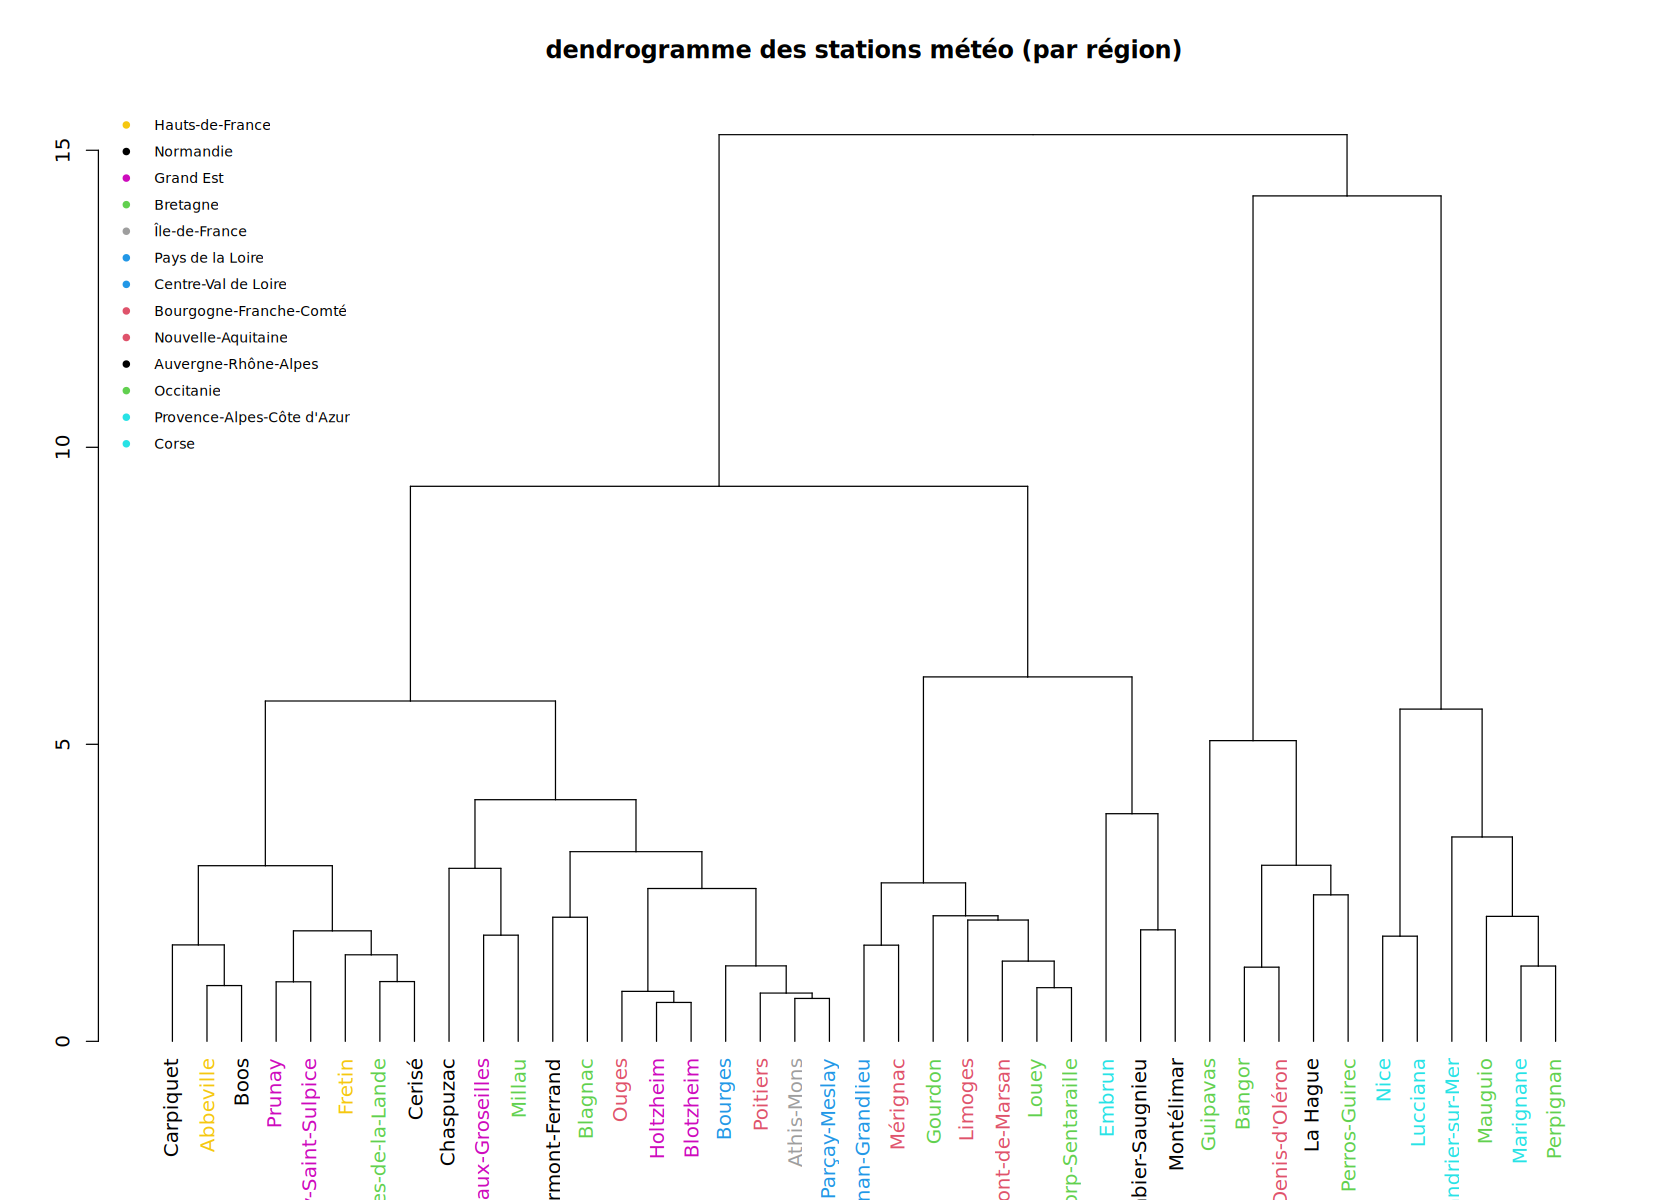

In [ ]:
d <- dist(data_scaled, method = "euclidean")
hc_res <- hclust(d, method = "ward.D2")

dend <- as.dendrogram(hc_res)
regions <- stations_france$region..name.
region_colors <- as.numeric(as.factor(regions))  # transforme chaque région en un code couleur
labels_colors(dend) <- region_colors[order.dendrogram(dend)] 

options(repr.plot.width=14, repr.plot.height=10) 
par(bg = 'white')
plot(dend, main = "dendrogramme des stations météo (par région)",
     cex = 0.6, hang = -1)

legend("topleft", legend = unique(regions),
       col = unique(region_colors), pch = 19, cex = 0.7, bty = "n")

Enfin, on plot les résultats sur la carte de la France métropolitaine

In [16]:
clusters_hc <- cutree(hc_res, k = 6)
stations_france$cluster <- factor(clusters_hc)

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


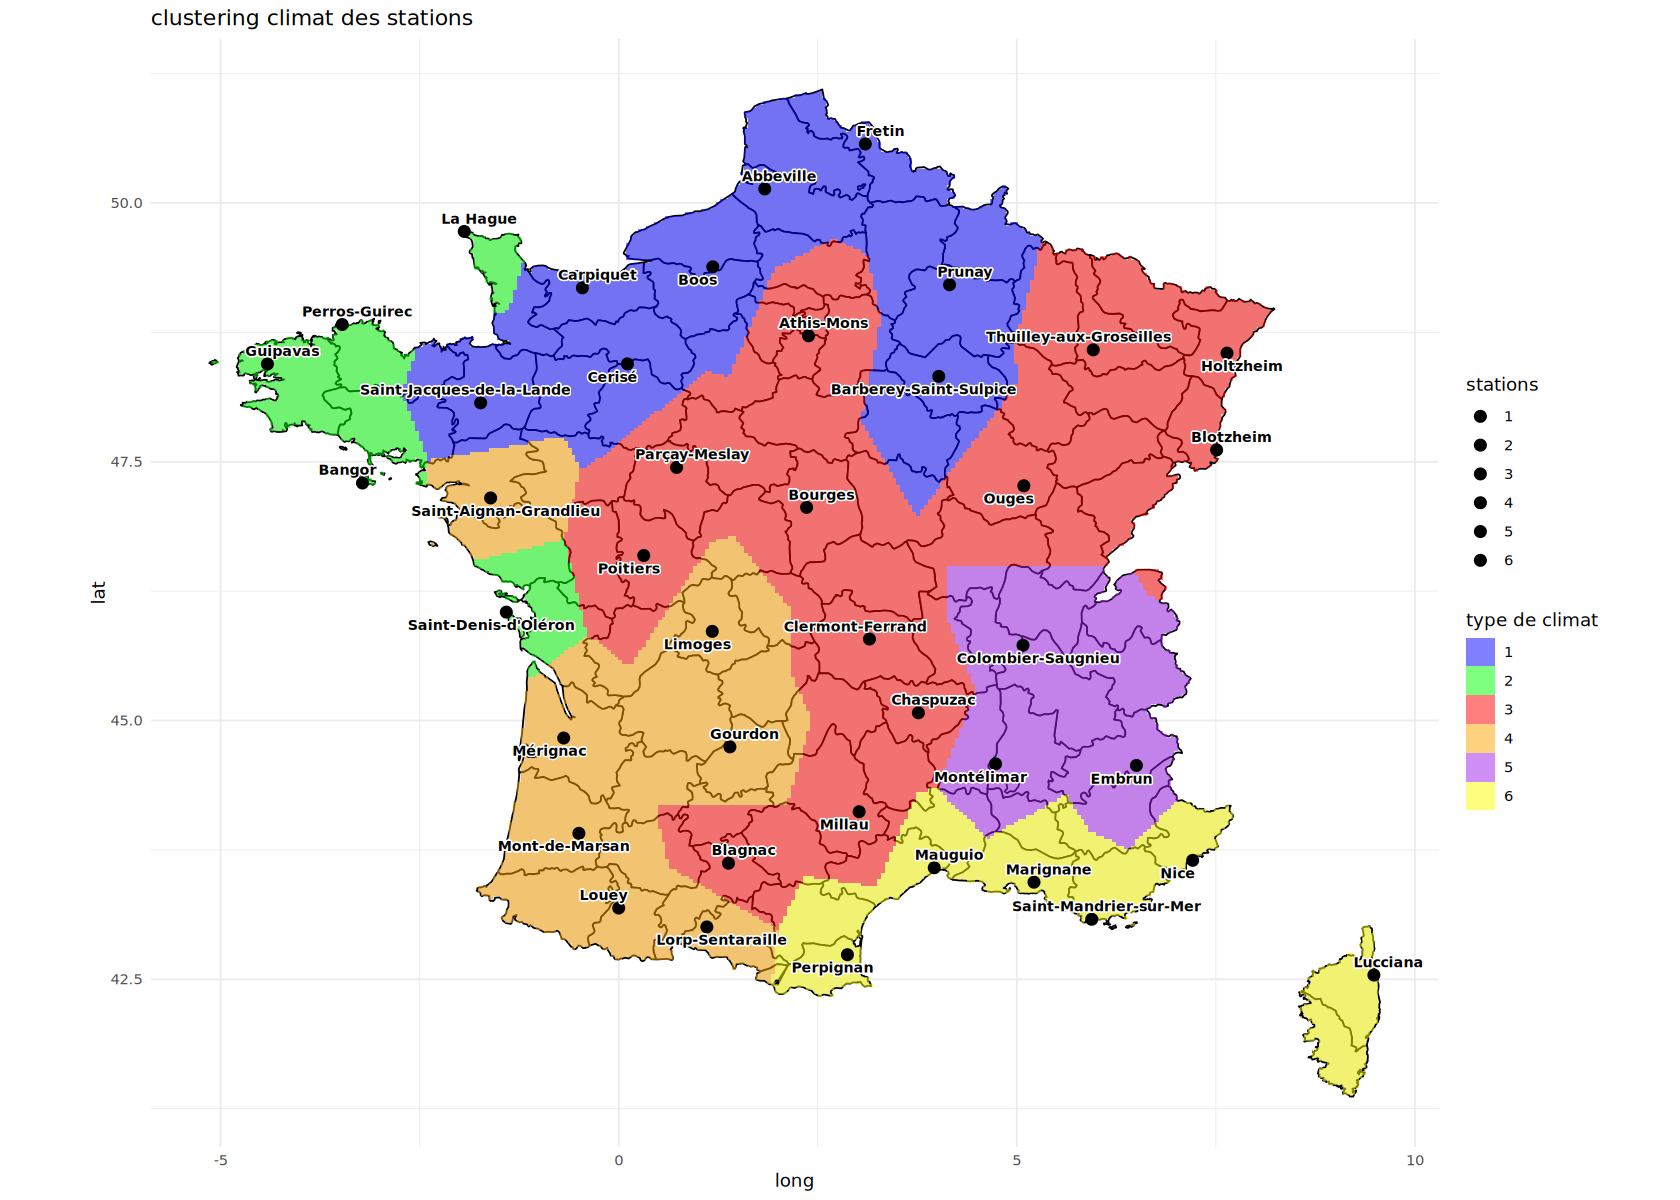

In [17]:
france_map <- map_data("france")

x_seq <- seq(min(france_map$long), max(france_map$long), length.out = 300)
y_seq <- seq(min(france_map$lat), max(france_map$lat), length.out = 300)
grid <- expand.grid(Longitude = x_seq, Latitude = y_seq)

inside_any <- rep(0, nrow(grid))

for(g in unique(france_map$group)){
  poly <- france_map[france_map$group == g, ]
  inside <- point.in.polygon(grid$Longitude, grid$Latitude,
                             poly$long, poly$lat)
  inside_any <- pmax(inside_any, inside)
}

grid <- grid[inside_any > 0, ]

nn <- get.knnx(stations_france[,c("Longitude","Latitude")], 
               grid, k = 1)
grid$cluster <- stations_france$cluster[nn$nn.index]

ggplot() +
  geom_polygon(data = france_map,
               aes(x = long, y = lat, group = group),
               fill = "grey90", color = "black") +
  geom_raster(data = grid,
              aes(x = Longitude, y = Latitude, fill = cluster),
              alpha = 0.5) +
  geom_point(data = stations_france,
             aes(x = Longitude, y = Latitude, color = cluster),
             size = 2) +
  
  geom_point(data = stations_france,
             aes(x = Longitude, y = Latitude, color = cluster),
             size = 3) +
  geom_text_repel(data = stations_france,
                  aes(x = Longitude, y = Latitude, 
                      label = communes..name., color = cluster),
                  size = 3, max.overlaps = 20,
                  fontface = "bold",
                  bg.color = "white", bg.r = 0.15) + # surlignage des textes
  
  coord_fixed(1.3, xlim = range(france_map$long), ylim = range(france_map$lat)) +
  theme_minimal() +
  labs(title = "clustering climat des stations",
       fill = "type de climat", color = "stations") +
  scale_fill_manual(values = c(
    "1" = "blue",
    "2" = "green",
    "3" = "red",
    "4" = "orange",
    "5" = "purple",
    "6" = "yellow"
  )) +
  scale_color_manual(values = c(
    "1" = "black",
    "2" = "black",
    "3" = "black",
    "4" = "black",
    "5" = "black",
    "6" = "black"
  ))
